# Plot spider


In [177]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from collections import OrderedDict

from local_python.general_utils import select_and_sort_dataframe
from local_python.radar_chart import radar_factory

In [178]:
path_f1_scores_grouped = "../results/f1_scores.csv"
print_baseline = False
selected_architecture = ["ResNet50", "ViT_T16"][0]

In [179]:
colors = []
columns = []
column_labels = []

if "ResNet50" == selected_architecture:
    colors = [
        "r",
        "b",
        # "skyblue",
        "limegreen",
        "black",
    ]
    columns = [
        "Derma_SSL_SimCLR",
        "ImageNet_1k_SL_V1",
        # "ImageNet_1k_SSL_SimCLR",
        "PDDD",
        "Random",
    ]
    column_labels = [
        "Dermatology SSL",
        "ImageNet SL",
        # "ImageNet SSL",
        "Plant SL",
        "Random",
    ]
elif "ViT_T16" == selected_architecture:
    colors = [
        "r",
        # "skyblue",
        "b",
        # "m",
        "limegreen",
        "black",
    ]
    columns = [
        "Derma",
        # "ImageNet_1k_SL_WinKawaks",
        "ImageNet_1k_SSL_Dino",
        # "ImageNet_AugReg",
        "Plant",
        "Random",
    ]
    column_labels = [
        "Dermatology SSL",
        # "ImageNet SL",
        "ImageNet SSL",
        # "ImageNet AR",
        "Plant SSL",
        "Random",
    ]
else:
    print(f"Unknown architecture selected: {selected_architecture}")

In [180]:
def filter_and_unstack(df, filter_config):
    for filter_key, filter_list in filter_config.items():
        assert (
            filter_key in df.columns.values
        ), f"No column found with name {filter_key}"
        df = df[df[filter_key].isin(filter_list)]
    df = df[
        [
            "downstream",
            "pre-training",
            "f1_macro_mean",
            "f1_macro_std",
            # "f1_macro_count",
        ]
    ]
    df["downstream"] = pd.Categorical(
        df["downstream"],
        [col for col in dataset_order if col in df["downstream"].unique()],
    )
    return df.set_index(["pre-training", "downstream"]).unstack(level=0)

def plot_spider_axis(ax, title, df_plot, legend_elements):
    for i, column in enumerate(columns):
        color = colors[i] if i < len(colors) else None
        edgecolor = to_rgba(color, alpha=0.6)
        facecolor = to_rgba(color, alpha=0.2)

        ax.set_theta_offset(rotation_offset)
        mean_values = df_plot[("f1_macro_mean", column)].values
        std_values = df_plot[("f1_macro_std", column)].values
        ax.plot(
            theta, mean_values, color=edgecolor, label="_nolegend_"
        )
        min_values = mean_values - std_values
        max_values = mean_values + std_values
        ax.fill_between(
            [*theta, theta[0]],
            [*min_values, min_values[0]],
            [*max_values, max_values[0]],
            facecolor=facecolor,
            label=column,
        )
        legend_elements[column_labels[i]] = Patch(
            facecolor=facecolor,
            edgecolor=edgecolor,
            label=column_labels[i],
        )

    ax.set_rgrids([0.2, 0.4, 0.6, 0.8])
    ax.set_title(title)
    ax.set_varlabels(df_plot["f1_macro_mean"].index)
    # light_red = (0.95, 0.9, 0.9)
    # light_green = (0.9, 0.95, 0.9)
    # ax.legend(df_plot.index.values, loc=(0.9, 0.95), labelspacing=0.1, fontsize="small")
    # north = np.pi / 2 - rotation_offset
    # ax.axvspan(north, np.pi + north, facecolor=light_red, alpha=0.7)
    # ax.axvspan(np.pi + north, 2 * np.pi + north, facecolor=light_green, alpha=0.7)

In [181]:
column_order_dataset_order = [
    "PlantDoc", # smallest plant dataset
    "DDI",  # smallest derma dataset
    "PAD-UFES-20",
    "HAM10000",
    "Fitzpatrick17k",  # largest derma dataset
    "PlantVillage",  # largest plant dataset
    "Cassava",
    "PlantDataset",
]


df_master = pd.read_csv(path_f1_scores_grouped, index_col=0, 
    dtype={
        "downstream": pd.CategoricalDtype(
            categories=column_order_dataset_order, ordered=True
        )
    },)
df_master

,architecture,downstream,pre-training,number_of_samples,model_name,f1_macro_mean,f1_macro_std,f1_macro_count
0,ResNet50,Cassava,Derma_SSL_SimCLR,1,dc,0.019217,0.000000,100
1,ResNet50,Cassava,Derma_SSL_SimCLR,1,knn,0.184686,0.035744,100
2,ResNet50,Cassava,Derma_SSL_SimCLR,1,lr,0.163515,0.045919,100
3,ResNet50,Cassava,Derma_SSL_SimCLR,10,dc,0.019217,0.000000,100
4,ResNet50,Cassava,Derma_SSL_SimCLR,10,knn,0.208679,0.018469,100
...,...,...,...,...,...,...,...,...
1480,ViT_T16,PlantVillage,Random,3,knn,0.128046,0.010907,100
1481,ViT_T16,PlantVillage,Random,3,lr,0.175155,0.013696,100
1482,ViT_T16,PlantVillage,Random,30,dc,0.000604,0.000000,100
1483,ViT_T16,PlantVillage,Random,30,knn,0.205410,0.007056,100


In [182]:
df_plot_l = filter_and_unstack(
    df_master,
    {
        "number_of_samples": ["None"],
        "architecture": [selected_architecture],
        "model_name": ["knn"],
    },
)

df_plot_r = filter_and_unstack(
    df_master,
    {
        "number_of_samples": ["None"],
        "architecture": [selected_architecture],
        "model_name": ["lr"],
    },
)

df_plot_d = filter_and_unstack(
    df_master,
    {
        "number_of_samples": ["None"],
        "architecture": [selected_architecture],
        "model_name": ["dc"],
    },
)

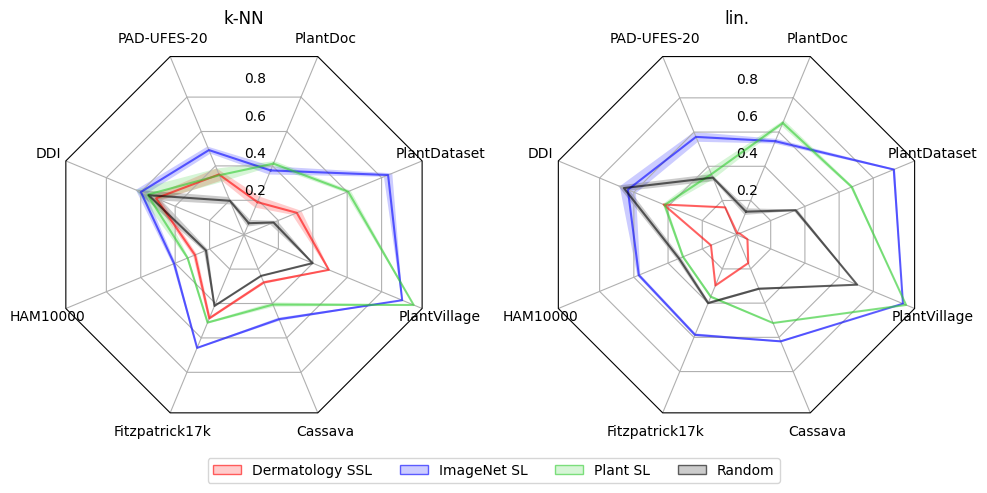

In [183]:
baseline_postfix = ""

number_of_categories = len(dataset_order)
rotation_offset = np.pi / 2 - np.pi / number_of_categories

theta = radar_factory(
    number_of_categories, frame="polygon", rotation_offset=rotation_offset
)

fig, axes = plt.subplots(
    figsize=(10, 5),
    nrows=1,
    ncols=2,
    subplot_kw=dict(projection="radar"),
    squeeze=False,
)
legend_elements = {}
if print_baseline:
    baseline_postfix = "_baseline"
    plot_spider_axis(axes.flat[0], "baseline", df_plot_d, legend_elements)
    plot_spider_axis(axes.flat[1], "baseline", df_plot_d, legend_elements)

plot_spider_axis(axes.flat[0], "k-NN", df_plot_l, legend_elements)
plot_spider_axis(axes.flat[1], "lin.", df_plot_r, legend_elements)

fig.tight_layout()
fig.legend(
    handles=list(legend_elements.values()),
    loc="upper center",
    bbox_to_anchor=(0.5, 0.05),
    ncol=len(legend_elements),
)

postfix = selected_architecture.lower().replace(" ", "_") + baseline_postfix
plt.savefig(f"../images/spider_{postfix}.png", bbox_inches="tight")